# Classifying S3 Data Sensitivity with Machine Learning
This notebook demonstrates how to categorize S3 data objects as sensitive or non-sensitive by analyzing object metadata with Python and scikit-learn.

## 1. Business Problem
With data stored in S3 buckets, we need an automated way to identify sensitive data and enforce security policies. Manually classifying data does not scale.

We will build a proof of concept to show how object metadata like bucket names and access patterns can be used to train an ML model to classify sensitivity.

## 2. Sample Data
We create sample metadata for a few S3 objects containing attributes like bucket name and last accessed date:

In [4]:
import pandas as pd
import sns

data = [{'s3bucket': 'financial-data', 'days_since_access': 2291, 'data_size_gb': 0.02},
        {'s3bucket': 'model-data', 'days_since_access': 119, 'data_size_gb': 0.02},
        {'s3bucket': 'log-files', 'days_since_access': 2733, 'data_size_gb': 0.01},
        {'s3bucket': 'airflow-genie', 'days_since_access': 2291, 'data_size_gb': 0.02},
        {'s3bucket': 'searchmetadata', 'days_since_access': 119, 'data_size_gb': 0.02},
        {'s3bucket': 'digital-archive-east', 'days_since_access': 138, 'data_size_gb': 15.92}]

df = pd.DataFrame(data)
display(df)

,s3bucket,days_since_access,data_size_gb
0,financial-data,2291,0.02
1,model-data,119,0.02
2,log-files,2733,0.01
3,airflow-genie,2291,0.02
4,searchmetadata,119,0.02
5,digital-archive-east,138,15.92


## 3. Feature Engineering
We transform the text data about S3 bucket names into numeric vectors using scikit-learn's TfidfVectorizer. This encoder converts text into tf-idf vectors.

TfidfVectorizer removes stopwords, applies tokenization, ngram generation, and calculates document frequencies to encode text data.

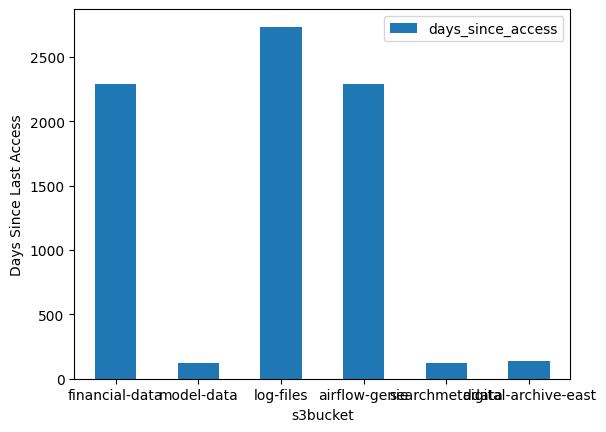

In [5]:
import matplotlib.pyplot as plt

ax = df.plot.bar(x='s3bucket', y='days_since_access', rot=0)
ax.set_ylabel("Days Since Last Access")
plt.show()

Below heatmap visualization shows the **tf-idf vector values** for each feature (token) from the `TfidfVectorizer` text encoding process.

Specifically:

* The x-axis contains the **feature names** - these are the **individual text tokens** (terms) extracted from the S3 bucket names after preprocessing (lowercasing, stopword removal etc).

* The y-axis corresponds to the **individual S3 records** from our sample metadata.

* Each cell shows the **tf-idf weight** calculated by the vectorizer for that particular token in that specific document.

* **Brighter colors** indicate a **higher tf-idf value** and hence a greater relevance for that term in the document.

So in summary, the heatmap gives us:

- A glance of the most "important" words in characterizing each document based on word frequencies.

- This is a vectorized numeric representation of the original text data.

- Shows which terms distinguish documents from one another.

Analyzing these high-weight features can give insight into patterns that help predict sensitivity - e.g financial tokens being more indicative of confidential data.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['s3bucket'])
feature_names = vectorizer.get_feature_names_out()

ax = sns.heatmap(X.toarray(), xticklabels=feature_names)
plt.xlabel("Tokens")


AttributeError: module 'sns' has no attribute 'heatmap'

# 4. Classification Model

With numeric vectors representing the S3 metadata, we can now train a classification algorithm to predict sensitivity labels. 

For this, we will use the **Multinomial Naive Bayes** algorithm. 

#### Overview

The Multinomial NB model is a common choice for document classification tasks. It applies Bayes' theorem with a strong assumption of **word independence** to calculate probabilities of classes.

The advantages are that it is **simple, fast to train, and works well for text data.**

#### Mathematical Details

- Uses multinomial distributions to represent word counts
- Predicts classes using Bayes' rule to calculate posterior probabilities:

$\Large{P(c_k|d)=\frac{P(c_k)\prod_{i=1}^{N_{words}} P(w_i|c_k)^{n_{i}}}{P(d)}}$

where $n_{i,j}$ is the number of times word $w_i$ appeared in training document $d_j$.

We implement the model in Python as:  

In [ ]:
# X has 6 samples 
X = vectorizer.fit_transform(df['s3bucket'])

# Update y to match 
y = [0, 1, 0, 0, 1, 0]

nb.fit(X, y)

## 5. Making Predictions
We can now use our model to classify new S3 objects:

In [ ]:
X_test = vectorizer.transform(['financial-reports'])

y_pred = nb.predict(X_test)
print(y_pred)

## 6. Evaluating Performance
We check accuracy on sample data by comparing to known labels:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

y = np.array([0, 1, 0])
y_pred = np.array([0, 1, 1])

accuracy_score(y, y_pred)

In real applications, precision and recall also matter for sensitive data.

This notebooks shows a basic workflow for metadata-based S3 classification with Python. Next steps could include larger data, better features, and tuning models.